![logo](figures/tdc-logo-post.png)

# THE DEVELOPER'S CONFERENCE - TDC 2022

## Trilha QUANTUM COMPUTING

## Aplicando o algoritmo de Grover e qRAM para resolver o puzzle game lights out

Autor: José Victor Soares Scursulim

Mestre em Física | IBM Qiskit Advocate | Certified Qiskit Developer

[LinkedIn](https://www.linkedin.com/in/jos%C3%A9-victor-soares-scursulim-9406931b4/) | [Qiskit_Advocates](https://qiskit.org/advocates/)


![qiskit](figures/qiskit_logo.png)

Importando as funções e classes que serão utilizadas nesse tutorial.

In [1]:
import numpy as np
from qiskit import Aer, execute
from qiskit.circuit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram, plot_state_qsphere
from lights_out import LightsOut
from solver import LightsOutSolver

Definindo um simulador QASM e um simulador de vetor de estado para realizar os experimentos. 

In [2]:
qasm = Aer.get_backend("qasm_simulator")
statevec = Aer.get_backend("statevector_simulator")
shots = 8192

## Definições

Os estados $|0\rangle$ e $|1\rangle$ são representados pelos seguintes vetores coluna:

$|0\rangle = \left[\begin{array}{c}1 \\ 0 \end{array}\right]$ e $|1\rangle = \left[\begin{array}{c}0 \\ 1 \end{array}\right]$.

## 1) Algoritmo de Grover

O algoritmo de Grover é um dos primeiros algoritmos quânticos que foram desenvolvidos. Ele recebeu esse nome em homenagem ao seu criador Lov K. Grover, que em 1996 [[1](https://arxiv.org/abs/quant-ph/9605043)], demonstrou que este algoritmo quântico seria capaz de realizar buscas não estruturadas, mais rápido que qualquer algoritmo clássico. 

Imagine que precisamos realizar uma consulta em uma base de dados não estruturada, que contém um número $N$ grande de itens, sendo assim na melhor das hipóteses encontraríamos o item de interesse em 1 consulta, na pior teríamos que percorrer toda a base, ou seja, realizar $N$ consultas. Na média, precisamos de $N/2$ consultas para encontrar o que queremos. A complexidade computacional dos algoritmos clássicos é $O(N)$, enquanto que o algoritmo de Grover, usando a superposição de estados, fase relativa e interferência da amplitude de probabilidade, nos fornece a resposta em $O(\sqrt{N})$ consultas, ou seja, ele nos dá um ganho quadrático de performance. Este algoritmo ilustra bem como as características peculiares da física quântica podem ser usadas para pensar um algoritmo.

Originalmente, o algoritmo de Grover foi pensando para acelerar buscas em base de dados não estruturadas, mas com o passar do tempo, foram encontradas outras aplicações, por exemplo: em problemas de otimização ("satisfiability") [[2](https://www.youtube.com/watch?v=ePr2MgQkqL0&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=6)] e na solução de sistemas de equações em módulo 2 (vamos explorar essa aplicação neste jupyter notebook) [[3](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/exercises/week-2/ex_2a_en.ipynb)] [[4](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/exercises/week-2/ex_2b_en.ipynb)].

Dando início a parte de código deste tutorial, vamos definir duas variáveis, a primeira vamos chamar de `qubits` e a ela vamos atribuir um `QuantumRegister`. A segunda variável será chamada de `qc` e receberá um `QuantumCircuit`, que recebe `qubits` como input.

Obs: Estamos definindo o tamanho do `QuantumRegister` igual a 2, pois em nosso exemplo vamos trabalhar com 4 elementos.

In [3]:
qubits = QuantumRegister(size = 2, name = "database")
qc = QuantumCircuit(qubits)

As variáveis definidas acima serão usadas para explorar as etapas que definem o algoritmo de Grover.

Primeiro vamos analisar o caso mais simples, consideremos que nosso banco de dados seja formado por  $N = 4$ itens que são mapeados nos seguintes estados:

$|00\rangle = \left[\begin{array}{c} 1 \\ 0 \\ 0 \\ 0 \end{array}\right]$,
$|01\rangle = \left[\begin{array}{c} 0 \\ 1 \\ 0 \\ 0 \end{array}\right]$,
$|10\rangle = \left[\begin{array}{c} 0 \\ 0 \\ 1 \\ 0 \end{array}\right]$,
$|11\rangle = \left[\begin{array}{c} 0 \\ 0 \\ 0 \\ 1 \end{array}\right]$.

Para criarmos a nossa base de dados não estruturados com 4 elementos, precisamos colocar dois qubits em superposição, de forma que o seguinte estado seja criado:

$|\psi\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$.

Note que cada elemento possui uma probabilidade de medição igual a 25%, uma vez que $p(|00\rangle) = p(|01\rangle) = p(|10\rangle) = p(|11\rangle) = {\vert\frac{1}{2}\vert}^2 = 0.25$. Para criarmos o estado $|\psi\rangle$, precisaremos usar a porta Hadamard ($H$), cuja representação matricial é dada por:

$H = \frac{1}{\sqrt{2}}\left[\begin{array}{cc} 1 & 1 \\ 1 & -1 \end{array}\right]$.

Atuação de $H$ sobre $|0\rangle$ e $|1\rangle$:

$H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) = |+\rangle$ e $H|1\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle) = |-\rangle$.

Lembrando que inicialmente todos os qubits em um circuto encontram-se no estado $|0\rangle$, e que em nosso circuito temos 2 qubits, então nosso estado inicial é $|00\rangle$ ($|00\rangle = |0\rangle \otimes |0\rangle$). Aplicando a porta Hadamard em ambos os qubits:

$H \otimes H|00\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$,

onde $\otimes$ representa o produto tensorial. É importante ressaltar que inicialmente os qubits devem estar no estado $|0\rangle$, pois assim evitamos a introdução de fases relativas indesejadas que podem atrapalhar na resposta final.

Criando o estado $|\psi\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$ através de código.

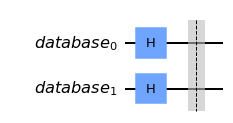

In [4]:
qc.h(qubit = qubits)
qc.barrier()
# O método draw cria uma representação gráfica do circuito
qc.draw(output = "mpl")

A figura acima mostra um circuito quântico com 2 qubits, onde foram aplicadas duas portas Hadamard.
Obs: O comando `qc.barrier()` cria uma barreira para organizar o circuito. 

Afim de demonstrar que de fato criamos o estado $|\psi\rangle = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)$, vamos plotar a Qsphere do estado gerado pelo circuito executado acima.

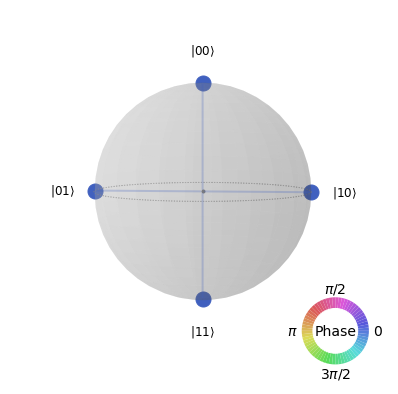

In [5]:
# Obtém o vetor de estado do circuito em questão
statevector = execute(experiments = qc, backend = statevec).result().get_statevector()
# Faz o plot da Qsphere do vetor de estado
plot_state_qsphere(statevector)

Na figura acima, podemos ver que temos os 4 elementos esperados e que nenhum deles apresenta fase relativa. Na mecânica quântica existem dois tipos de fase que os estados podem apresentar, estas são classificadas como globais e relativas, a primeira pode ser ignorada uma vez que não tem significado físico, já a segunda possui significado físico e pode ser introduzida por operadores.

$|\phi\rangle = e^{i\theta}(\alpha|0\rangle + \beta|1\rangle)$ (1) Exemplo de estado quântico com fase global $e^{i\theta}$.

$|\varphi\rangle = \alpha|0\rangle + e^{i\delta}\beta|1\rangle$ (2) Exemplo de estado quântico com fase relativa $e^{i\delta}$.

Lembrando que $\alpha,\beta \in \mathbb{C}$, ou seja, são números complexos e satisfazem a condição de normalização ${\vert\alpha\vert}^2 + {\vert\beta\vert}^2 = 1$.

Na segunda etapa do algoritmo de Grover, usamos um operador chamado de oráculo, este é responsável por marcar o elemento que desejamos encontrar com uma fase relativa $e^{i\pi} = -1$. Este procedimento permite destacar o elemento de interesse $\omega$ dos demais. Além disso, esta adição da fase relativa é essencial para o truque de amplificação de amplitude de probabilidade, pois indica o elemento que deve ter sua amplitude de probabilidade aumentada. 

É possível definir o operador que representa o oráculo da seguinte forma [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)]: 

$U_{oracle}|x\rangle = \Big \{ \begin{array}{c} |x\rangle, x \neq \omega \\ -|x\rangle, x = \omega\end{array}$

onde $|x\rangle$ representa os estados quânticos de cada elemento da base de dados, e $\omega$ representa o elemento que desejamos encontrar. 

Exemplo: Oráculo para o estado $|11\rangle$

$U_{oracle|11\rangle} = \left[\begin{array}{cccc} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & -1\end{array}\right] = CZ$

$CZ = |0\rangle\langle0|\otimes\mathbb{I} + |1\rangle\langle1|\otimes Z$, onde $Z$ representa a matriz $Z = \left[\begin{array}{cc} 1 & 0 \\ 0 & -1\end{array}\right]$.

Atuando o oráculo definido acima sobre o estado $|\psi\rangle$:

$CZ|\psi\rangle = \frac{1}{2}(CZ|00\rangle + CZ|01\rangle + CZ|10\rangle + CZ|11\rangle) = \frac{1}{2}(|00\rangle + |01\rangle + |10\rangle - |11\rangle)$.

Para adicionarmos o oráculo apresentado acima ao nosso circuito, devemos usar o comando `qc.cz()` e passar como argumento o qubit de controle e o qubit alvo. Essas informações são necessárias, pois a porta $CZ$ é uma porta controloda, ou seja, ela aplica uma porta $Z$ no qubit alvo apenas quando o qubit de controle encontra-se no estado $|1\rangle$.

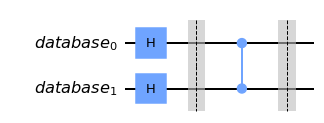

In [6]:
qc.cz(control_qubit = qubits[0], target_qubit = qubits[1])
qc.barrier()
qc.draw(output = "mpl")

![Figura_1](figures/grover_step1.jpg)

Figura 1: Representação geométrica do vetor que representa a superposição dos estados e o gráfico da amplitude de probabilidade de cada um dos elementos. Imagem retirada da referência [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)].

Oráculos para os elementos $|00\rangle$, $|01\rangle$ e $|10\rangle$.

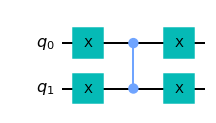

In [7]:
# Oráculo para marcar o estado |00>
oracle_00 = QuantumCircuit(2)
oracle_00.x(qubit = [0,1])
oracle_00.cz(control_qubit = 0, target_qubit = 1)
oracle_00.x(qubit = [0,1])
oracle_00.draw(output = "mpl")

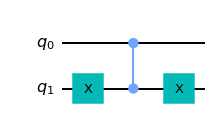

In [8]:
# Oráculo para marcar o estado |01>
oracle_01 = QuantumCircuit(2)
oracle_01.x(qubit = 1)
oracle_01.cz(control_qubit = 0, target_qubit = 1)
oracle_01.x(qubit = 1)
oracle_01.draw(output = "mpl")

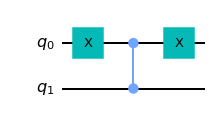

In [9]:
# Oráculo para marcar o estado |10>
oracle_10 = QuantumCircuit(2)
oracle_10.x(qubit = 0)
oracle_10.cz(control_qubit = 0, target_qubit = 1)
oracle_10.x(qubit = 0)
oracle_10.draw(output = "mpl")

Obs: A aplicação de portas NOT (ou $X$) antes e depois dos qubits de controle serve para garantir que a porta controlada seja ativada quando o input no controle estiver no estado $|0\rangle$.

![Figura_2](figures/grover_step2.jpg)

Figura 2: Representação geométrica da ação do oráculo, ou seja, marcar o elemento que desejamos encontrar com uma fase relativa -1, mantendo todos os estados com o módulo das amplitudes de probabilidade iguais. Imagem retirada da referência [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)].

Agora vamos fazer o plot da Qsphere para visualizarmos o vetor de estado após a aplicação do oráculo.

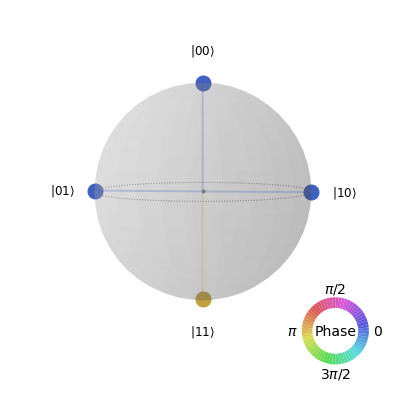

In [10]:
statevector = execute(experiments = qc, backend = statevec).result().get_statevector()
plot_state_qsphere(statevector)

Note que na figura acima, o estado $|11\rangle$ apresenta uma cor diferente dos demais estados, isso nos indica que de fato nosso oráculo cumpriu sua função de marcá-lo com uma fase relativa igual a -1.

Agora que temos nosso item de interesse marcado com uma fase relative igual a -1, devemos partir para o próximo passo do algoritmo de Grover, ou seja, o truque de amplificação de amplitude de probabilidade.

Após a aplicação das portas Hadamard no início do circuito, temos que todos os estados apresentam uma amplitude de probabilidade igual a $\frac{1}{\sqrt{2^n}}$, onde $n$ representa o número de qubits usados no circuito. Em nosso exemplo estamos trabalhando com $n = 2$, pois só precisamos de dois qubits para representar os estados $|00\rangle$, $|01\rangle$, $|10\rangle$ e $|11\rangle$, com isso temos que a amplitude dos estados é igual a $\frac{1}{2}$. Sendo assim, todos os estados apresentam uma probabilidade de serem medidos igual a $\frac{1}{4}$ (lembrando que a probabilidade é o quadrado do módulo da amplitude de probabilidade), contudo desejamos medir apenas o elemento de interesse ou que ele tenha uma probabilidade de medição muito próxima de 1. Para isso, devemos fazer o uso do truque de amplificação de amplitude, este consiste em duas reflexões que tendem aproximar o estado geral do elemento de interesse. Na Figura 2, podemos ver uma representação gráfica da ação desse truque.

![Figura_3](figures/grover_step3.jpg)

Figura 3: A representa a rotação realizada no vetor para que se tenha uma amplificação da amplitude de probabilidade do estado do elemento que queremos encontrar. Imagem retirada da referência [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)].

A sequência de portas aplicadas ao nosso circuito na célula de código abaixo, define o truque de amplificação de amplitude.

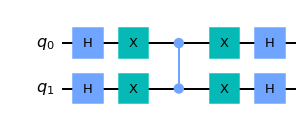

In [11]:
amplitude_amplifier = QuantumCircuit(2)
amplitude_amplifier.h(qubit = [0,1])
amplitude_amplifier.x(qubit = [0,1])
amplitude_amplifier.cz(control_qubit = 0, target_qubit = 1)
amplitude_amplifier.x(qubit = [0,1])
amplitude_amplifier.h(qubit = [0,1])
amplitude_amplifier.draw(output = "mpl")

Versão alternativa da sequência de portas que definem o truque de amplificação de amplitude.

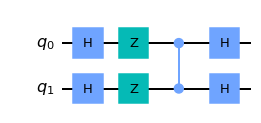

In [12]:
amplitude_amplifier_alternative = QuantumCircuit(2)
amplitude_amplifier_alternative.h(qubit = [0,1])
amplitude_amplifier_alternative.z(qubit = [0,1])
amplitude_amplifier_alternative.cz(control_qubit = 0, target_qubit = 1)
amplitude_amplifier_alternative.h(qubit = [0,1])
amplitude_amplifier_alternative.draw(output = "mpl")

Aplicando a primeira versão do truque apresentada ao nosso circuito, temos:

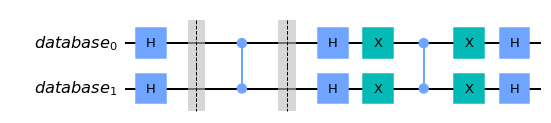

In [13]:
qc.h(qubit = qubits)
qc.x(qubit = qubits)
qc.cz(control_qubit = qubits[0], target_qubit = qubits[1])
qc.x(qubit = qubits)
qc.h(qubit = qubits)

qc.draw(output = "mpl")

Dado que a computação quântica é intrinsecamente probabilística, é preciso garantir que o estado com elemento que queremos encontrar tenha a maior probabilidade de ser medido, sendo assim se faz necessário repetir o procedimento de aplicar o oráculo e o amplificador de amplitude algumas vezes. Podemos interpretar isso graficamente como o vetor se aproximando do eixo y da Figura 2 a cada rodada de rotações. No nosso exemplo com $N = 4$, só é necessário aplicar o oráculo e realizar o truque de amplificação de amplitude apenas uma vez, como indicado pelo cálculo abaixo.

In [14]:
N = 4
theta = np.arcsin(1/np.sqrt(N))
t = int(np.round(((np.pi/2) - theta)/2))
print(f"Para N = {N}, precisamos aplicar o oráculo e realizar o truque de amplificação de amplitude {t} vez.")

Para N = 4, precisamos aplicar o oráculo e realizar o truque de amplificação de amplitude 1 vez.


Para maiores detalhes sobre o resultado acima, favor consultar as referências [[1](https://arxiv.org/abs/quant-ph/9605043)], [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)] e [[6](https://youtu.be/iJX794qJIpY?t=1394)].

Após todos os procedimentos, o estado final deve ser igual ao representado pela Qsphere abaixo.

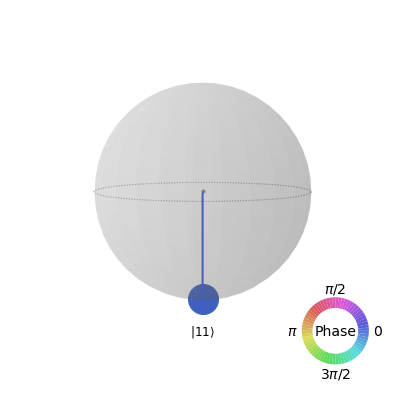

In [15]:
statevector = execute(experiments = qc, backend = statevec).result().get_statevector()
plot_state_qsphere(statevector)

Em resumo:

As etapas do algoritmo de Grover são

1. Definir a base de dados.
2. Criar o oráculo para marcar o(s) item(ns) que desejamos encontrar.
3. Aplicar o truque de amplificação de amplitude de probabilidade.
4. Encontrar o número de repetições dos procedimentos 2 e 3 e realizá-las.
5. Medir os qubits.

Exemplo: Algoritmo de Grover aplicado para N = 8 com o objetivo de encontrar o estado $|101\rangle$.

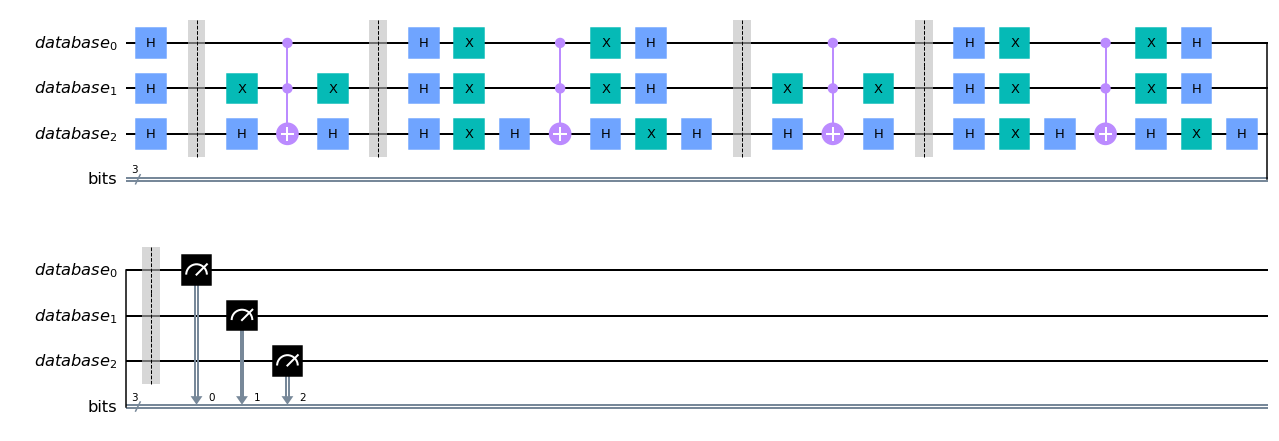

In [16]:
qubits = QuantumRegister(size = 3, name = "database")
bits = ClassicalRegister(size = 3, name = "bits")
qc = QuantumCircuit(qubits, bits)

qc.h(qubit = qubits)
qc.barrier()
for _ in range(2):
    
    qc.x(qubit = qubits[1])
    qc.h(qubit = qubits[-1])
    qc.mct(control_qubits = qubits[:2], target_qubit = qubits[-1])
    qc.h(qubit = qubits[-1])
    qc.x(qubit = qubits[1])
    qc.barrier()
    qc.h(qubit = qubits)
    qc.x(qubit = qubits)
    qc.h(qubit = qubits[-1])
    qc.mct(control_qubits = qubits[:2], target_qubit = qubits[-1])
    qc.h(qubit = qubits[-1])
    qc.x(qubit = qubits)
    qc.h(qubit = qubits)
    qc.barrier()
qc.measure(qubit = qubits, cbit = bits)
qc.draw(output = "mpl")

Note que nosso circuito para o caso N = 8, apresenta portas CNOT com dois qubits de controle e que a porta NOT no qubit alvo tem uma porta Hadamard antes e depois. Essa porta CNOT com dois qubits de controle e com a porta NOT com portas Hadamard antes e depois é equivalente a uma porta CZ com dois qubits de controle, isso se deve a seguinte relação:

$Z = HXH$.

No Qiskit não há uma porta CZ com vários controles, por isso utilizamos CNOT com mais de um controle na forma de `mct()`.

Agora vamos executar o circuito quântico criado para este exemplo usando o simulador QASM, em seguida vamos fazer o plot do histograma com o resultado desse experimento, ou seja, com as probabilides de ocorrência de cada estado. 

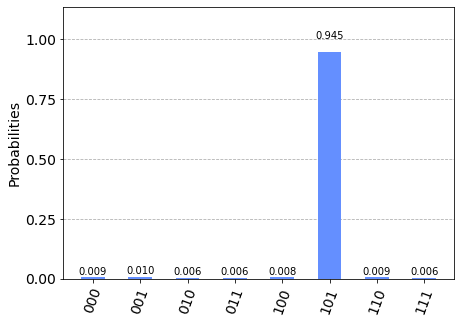

In [17]:
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
plot_histogram(counts)

Note que no histograma acima, o estado $|101\rangle$ aparece com a maior probabilide de ocorrência, o que era de se esperar, uma vez que ele é o estado que queríamos encontrar.

O algoritmo de Grover não se restringe a buscar apenas um item, podemos buscar mais de um item de uma vez. Para realizar uma busca com mais de um item é preciso adicionar mais oráculos ao circuito, dessa forma teremos mais de um item marcado. No exemplo abaixo, temos um circuito para encontrar os estados $|100\rangle$ e $|101\rangle$.

Exemplo: Algoritmo de Grover aplicado para N = 8 quando queremos encontrar os estados $|100\rangle$ e $|101\rangle$.

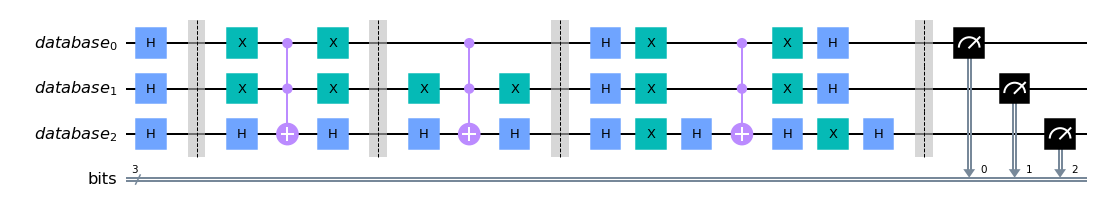

In [18]:
qubits = QuantumRegister(size = 3, name = "database")
bits = ClassicalRegister(size = 3, name = "bits")
qc = QuantumCircuit(qubits, bits)

qc.h(qubit = qubits)
qc.barrier()
for _ in range(1):
    
    qc.x(qubit = qubits[:2])
    qc.h(qubit = qubits[-1])
    qc.mct(control_qubits = qubits[:2], target_qubit = qubits[-1])
    qc.h(qubit = qubits[-1])
    qc.x(qubit = qubits[:2])
    qc.barrier()
    qc.x(qubit = qubits[1])
    qc.h(qubit = qubits[-1])
    qc.mct(control_qubits = qubits[:2], target_qubit = qubits[-1])
    qc.h(qubit = qubits[-1])
    qc.x(qubit = qubits[1])
    qc.barrier()
    qc.h(qubit = qubits)
    qc.x(qubit = qubits)
    qc.h(qubit = qubits[-1])
    qc.mct(control_qubits = qubits[:2], target_qubit = qubits[-1])
    qc.h(qubit = qubits[-1])
    qc.x(qubit = qubits)
    qc.h(qubit = qubits)
    qc.barrier()
qc.measure(qubit = qubits, cbit = bits)
qc.draw(output = "mpl")

Executando o circuito quântico exibido acima no simulador QASM, e plotando o histograma com o resultado dessa simulação, veremos que os únicos estados que aparecem são $|100\rangle$ e $|101\rangle$. 

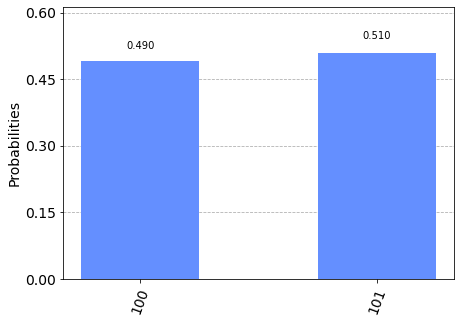

In [19]:
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
plot_histogram(counts)

Com isso terminamos as discussões sobre o algoritmo de Grover, caso o leitor queira mais informações, por favor consulte as referências [[1](https://arxiv.org/abs/quant-ph/9605043)], [[2](https://www.youtube.com/watch?v=ePr2MgQkqL0&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=6)], [[5](https://qiskit.org/textbook/ch-algorithms/grover.html)], [[6](https://youtu.be/iJX794qJIpY?t=1394)] e [[7](https://www.youtube.com/watch?v=0RPFWZj7Jm0&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=3)].

## 2) Quantum Random Access Memory - qRAM

A memória RAM (Random Access Memory), é um tipo de memória volátil usada nos computadores para armazenamento de dados e informações necessárias para a execução de aplicativos. A estrutura dessa memória possui um endereço que é associado a dados binários relacionados a este endereço. Uma memória RAM com $n$ bits endereça $N = 2^n$ células de memória distintas [[10](https://arxiv.org/pdf/0708.1879.pdf)].

Em 2008, Vittorio Giovannetti, Seth Lloyd e Lorenzo Maccone publicaram um paper onde propuseram uma memória de acesso aleatório quântica, a qRAM [[10](https://arxiv.org/pdf/0708.1879.pdf)]. Este tipo de memória faz uso de qubits para endereçar superposições quânticas em células de memória, para $n$ qubits podemos endereçar $N$ superposições. Espera-se que a qRAM possa acelerar tarefas como reconhecimento de padrões, transformada de Fourier quântica, em algoritmos de buscas e em algoritmo de quantum machine learning.

A qRAM pode ser implementada usando níveis de energia de átomos e dependendo do sistema físico, a dimensão do espaço de Hilbert pode ser maior que 2 (a dimensão do espaço dos qubits). Para facilitar a visualização e a implementação, vamos considerar a versão mais simples, ou seja, a bidimensional. Uma representação gráfica para esse tipo de estrutura são grafos bifurcados como o apresentado abaixo.

![binary_tree](figures/binary_tree.jpg)

A versão apresentada no artigo [[10](https://arxiv.org/pdf/0708.1879.pdf)] faz uso de qutrits (estados quânticos de três níveis) na implementação, contudo existe uma versão mais simples baseada em qubits que podemos usar. A implementação com qubits é feita através da adição de $n$ qubits em superposição ao circuito quântico para fazer o papel dos endereços da qRAM, e posteriormente são realizadas operações com portas de controle para associar as informações ao endereço. Utilizando a notação de Dirac, podemos escrever um estado quântico com qRAM da seguinte forma: 

$\sum_j\frac{1}{\sqrt{N}}|j\rangle_a|0\rangle_d \rightarrow \sum_j\frac{1}{\sqrt{N}}|j\rangle_a|D_j\rangle_d \ \textrm{(Estado depois do armazenamento de informação na qRAM)}$.

Note que $|j\rangle_a$ é o estado quântico para o endereço da qRAM, e $|D_j\rangle_d$ representa o estado com a informação associada ao $j$-ésimo endereço na memória.

Afim de deixar essa ideia menos abstrata, vamos construir um circuito quântico que implementa o comportamento esperado de uma qRAM. Na célula de código abaixo definimos as variáveis que serão usadas.

In [20]:
qubits = QuantumRegister(size = 3, name = "qubits")
qram_qubits = QuantumRegister(size = 2, name = "qram")
bits = ClassicalRegister(size = 3, name = "bits")
qram_bits = ClassicalRegister(size = 2, name = "qram_bits")

qc = QuantumCircuit(qubits, qram_qubits, bits, qram_bits)

De início, devemos aplicar portas Hadamard sobre os qubits que serão usados para criar a qRAM, isso deve ser feito para criar a superposição de endereços de memória, em nosso exemplo temos 2 qubits destinados a isso, sendo assim teremos 4 endereços de memória (00, 01, 10 e 11). Posteriormente, temos uma série de portas de controle e portas $X$ para poder associar algum tipo de informação aos endereços.

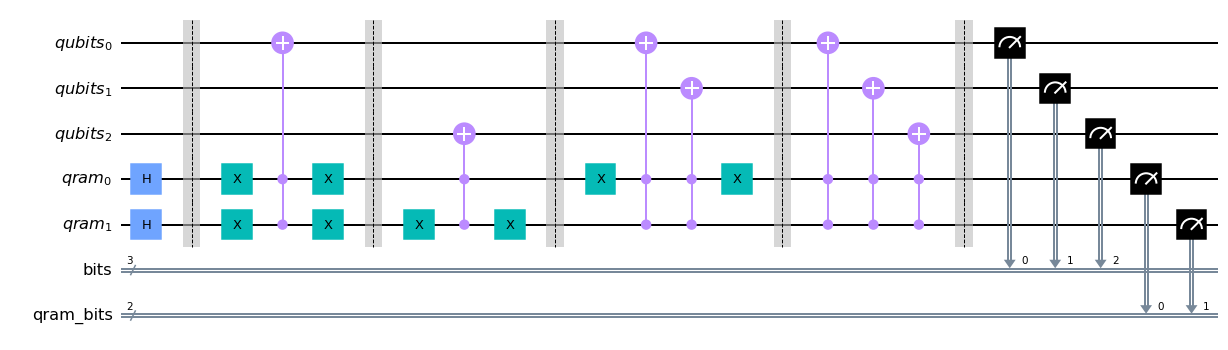

In [21]:
# Inicializando os endereços da QRAM
qc.h(qubit = qram_qubits)
qc.barrier()
# Associando uma informação ao endereço 00
qc.x(qubit = qram_qubits)
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[0])
qc.x(qubit = qram_qubits)
qc.barrier()
# Associando uma informação ao endereço 01
qc.x(qubit = qram_qubits[1])
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[2])
qc.x(qubit = qram_qubits[1])
qc.barrier()
# Associando uma informação ao endereço 10
qc.x(qubit = qram_qubits[0])
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[0])
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[1])
qc.x(qubit = qram_qubits[0])
qc.barrier()
# Associando uma informação ao endereço 11
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[0])
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[1])
qc.mct(control_qubits = qram_qubits, target_qubit = qubits[2])
qc.barrier()
# Medindo o estado quântico criado pelo circuito
qc.measure(qubit = qubits, cbit = bits)
qc.measure(qubit = qram_qubits, cbit = qram_bits)
qc.draw(output = "mpl")

Executando um experimento no simulador QASM para verificar que o circuito acima apresenta o comportamento esperado da qRAM.

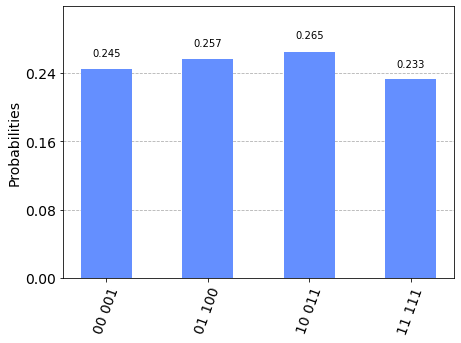

In [22]:
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
plot_histogram(counts)

No histograma acima, é possível ver que no endereço 00 da qRAM está armazenado o estado $|001\rangle$, já no endereço 01 temos o estado $|100\rangle$, no endereço 01 encontramos o estado $|011\rangle$ e por fim, no endereço 11 temos o estado $|111\rangle$. Sendo assim, o circuito definido anteriormente realiza o seu papel corretamente.

## 3) Lights Out Puzzle Game

Lights Out é um jogo eletrônico lançado pela Tiger Electronics em 1995 [[9](https://en.wikipedia.org/wiki/Lights_Out_(game))]. O objetivo do jogo é conseguir apagar todas as lâmpadas, com o menor número de ações possível, ativando e desativando lâmpadas no layout. No início, o jogo gera uma configuração aleatória do layout, a partir daí o jogar escolhe suas jogadas para tentar desativar todas as luzes. Ativar ou desativar uma lâmpada tem efeito sobre as vizinhas na horizontal e na vertical.

### 3.1) Exemplo 1: Usando o algoritmo de Grover para resolver jogos com layouts $2 \times 2$ e $3\times 3$

A figura abaixo mostra o mapeamento que estamos adotando para o layout do jogo, a matriz $n\times n$ do layout do jogo é mapeada em uma lista com $n^2$ elementos. Aqui consideramos os quadrados amarelos como lâmpadas acesas, representadas por 1, e os cinzas como lâmpadas apagadas, representadas por 0. No exemplo abaixo, temos um layout $2\times 2$ que é mapeado em uma lista/vetor com 4 entradas do tipo 0 ou 1.

![gmap2x2](figures/mapeamento_jogo.jpg)

Dado um layout inicial, nosso objetivo é conseguir apagar todas as lâmpadas do layout. Para isso, devemos acender ou apagar uma lâmpada de cada vez, lembrando que ao acender ou apagar uma lâmpada, ela era irá acender ou apagar as lâmpadas vizinhas na horizontal e na vertical. Na figura abaixo, temos uma representação gráfica e o mapeamento de cada jogada possível para um layout $2\times 2$.

![jogadas2x2](figures/jogadas_2x2.jpg)

Cada lista de jogadas define uma linha da matriz $A$, esta matriz nos permite definir um sistema de equações lineares cuja solução é a resposta para o jogo. De acordo com a referência [[9](https://mathworld.wolfram.com/LightsOutPuzzle.html)], as soluções podem ser expressas matematicamente através de: $Ax = L$, onde $x$ representa a solução e $L$ a matriz do layout inicial.

$Ax = L$

$\left[\begin{array}{cccc} 1 & 1 & 1 & 0 \\ 1 & 1 & 0 & 1 \\ 1 & 0 & 1 & 1 \\ 0 & 1 & 1 & 1\end{array}\right] \left[\begin{array}{c} x_1 \\ x_2 \\ x_3 \\ x_4\end{array}\right] = \left[\begin{array}{c} L_1 \\ L_2 \\ L_3 \\ L_4 \end{array}\right]$

Sistema de equações lineares em módulo 2

$(1) \ x_1 + x_2 + x_3 = L_1$

$(2) \ x_1 + x_2 + x_4 = L_2$

$(3) \ x_1 + x_3 + x_4 = L_3$

$(4) \ x_2 + x_3 + x_4 = L_4$

Aritmética em módulo 2:

$0 \oplus 0 = 0$

$0 \oplus 1 = 1$

$1 \oplus 0 = 1$

$1 \oplus 1 = 0$

A aritmética em módulo 2 pode ser implementada na computação através da porta XOR (Exclusive OR), cuja implementação em um circuito quântico pode ser feita através da porta CNOT [[10](https://qiskit.org/textbook/ch-states/atoms-computation.html)]. Sendo assim, temos que as equações que precisamos resolver podem ser escritas na forma de circuito quântico da seguinte forma:

Obs: Aqui vamos usar um qubit extra chamado `ancilla` para armazenar o resultado da soma em módulo 2.

In [23]:
qubits = QuantumRegister(size = 4, name = "x")
ancilla = QuantumRegister(size = 1, name = "resultado")

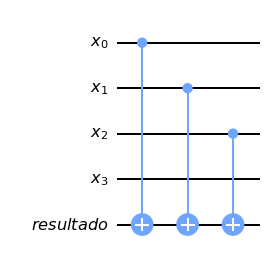

In [24]:
# Circuito para a equação 1
eq1 = QuantumCircuit(qubits, ancilla)

eq1.cx(control_qubit = qubits[0], target_qubit = ancilla)
eq1.cx(control_qubit = qubits[1], target_qubit = ancilla)
eq1.cx(control_qubit = qubits[2], target_qubit = ancilla)

eq1.draw(output = "mpl")

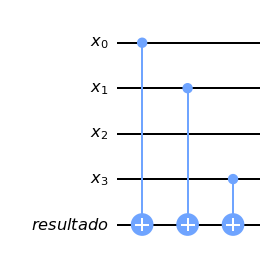

In [25]:
# Circuito para a equação 2
eq2 = QuantumCircuit(qubits, ancilla)

eq2.cx(control_qubit = qubits[0], target_qubit = ancilla)
eq2.cx(control_qubit = qubits[1], target_qubit = ancilla)
eq2.cx(control_qubit = qubits[3], target_qubit = ancilla)

eq2.draw(output = "mpl")

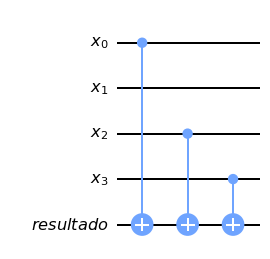

In [26]:
# Circuito para a equação 3
eq3 = QuantumCircuit(qubits, ancilla)

eq3.cx(control_qubit = qubits[0], target_qubit = ancilla)
eq3.cx(control_qubit = qubits[2], target_qubit = ancilla)
eq3.cx(control_qubit = qubits[3], target_qubit = ancilla)

eq3.draw(output = "mpl")

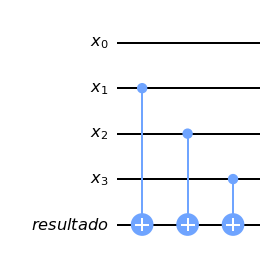

In [27]:
# Circuito para a equação 4
eq4 = QuantumCircuit(qubits, ancilla)

eq4.cx(control_qubit = qubits[1], target_qubit = ancilla)
eq4.cx(control_qubit = qubits[2], target_qubit = ancilla)
eq4.cx(control_qubit = qubits[3], target_qubit = ancilla)

eq4.draw(output = "mpl")

Agora vamos definir o jogo que queremos resolver, para isso vamos usar a lista $[0, 1, 1, 0]$ e passar ela como argumento da classe `LightsOut`. 

In [28]:
game = LightsOut(layout = [0, 1, 1, 0])

Sistema de equações lineares para o layout $[0,1,1,0]$

$(1) \ x_1 + x_2 + x_3 = 0$

$(2) \ x_1 + x_2 + x_4 = 1$

$(3) \ x_1 + x_3 + x_4 = 1$

$(4) \ x_2 + x_3 + x_4 = 0$

Para solucionar o jogo, vamos adicionar a variável `game1` a uma lista e passar ela como argumento para a classe `LightsOutSolver`. Esta classe possui os métodos para criar o circuito quântico que obtém a solução do jogo.  

In [29]:
lights_out_game_solver = LightsOutSolver(games = [game])

Note que o circuito abaixo, apresenta duas portas $X$ aplicadas aos qubits `ancilla_0` e `ancilla_3`, assim fazendo com que eles estejam no estado $|1\rangle$. Entretanto, no layout do jogo, as posições das lâmpadas 0 e 3 são iguais a 0, isso pode parecer um erro, mas na verdade não é, pois precisamos que o oráculo seja ativado na solução, para isso é necessário que o qubit de controle esteja no estado $|1\rangle$. Sendo assim, nas posições 0 e 3, a soma módulo 2 deve ser igual a 0 para que o qubit de controle permaneça no estado $|1\rangle$.

Este procedimento é um dos passos mais importantes, pois informa ao oráculo qual problema queremos resolver!

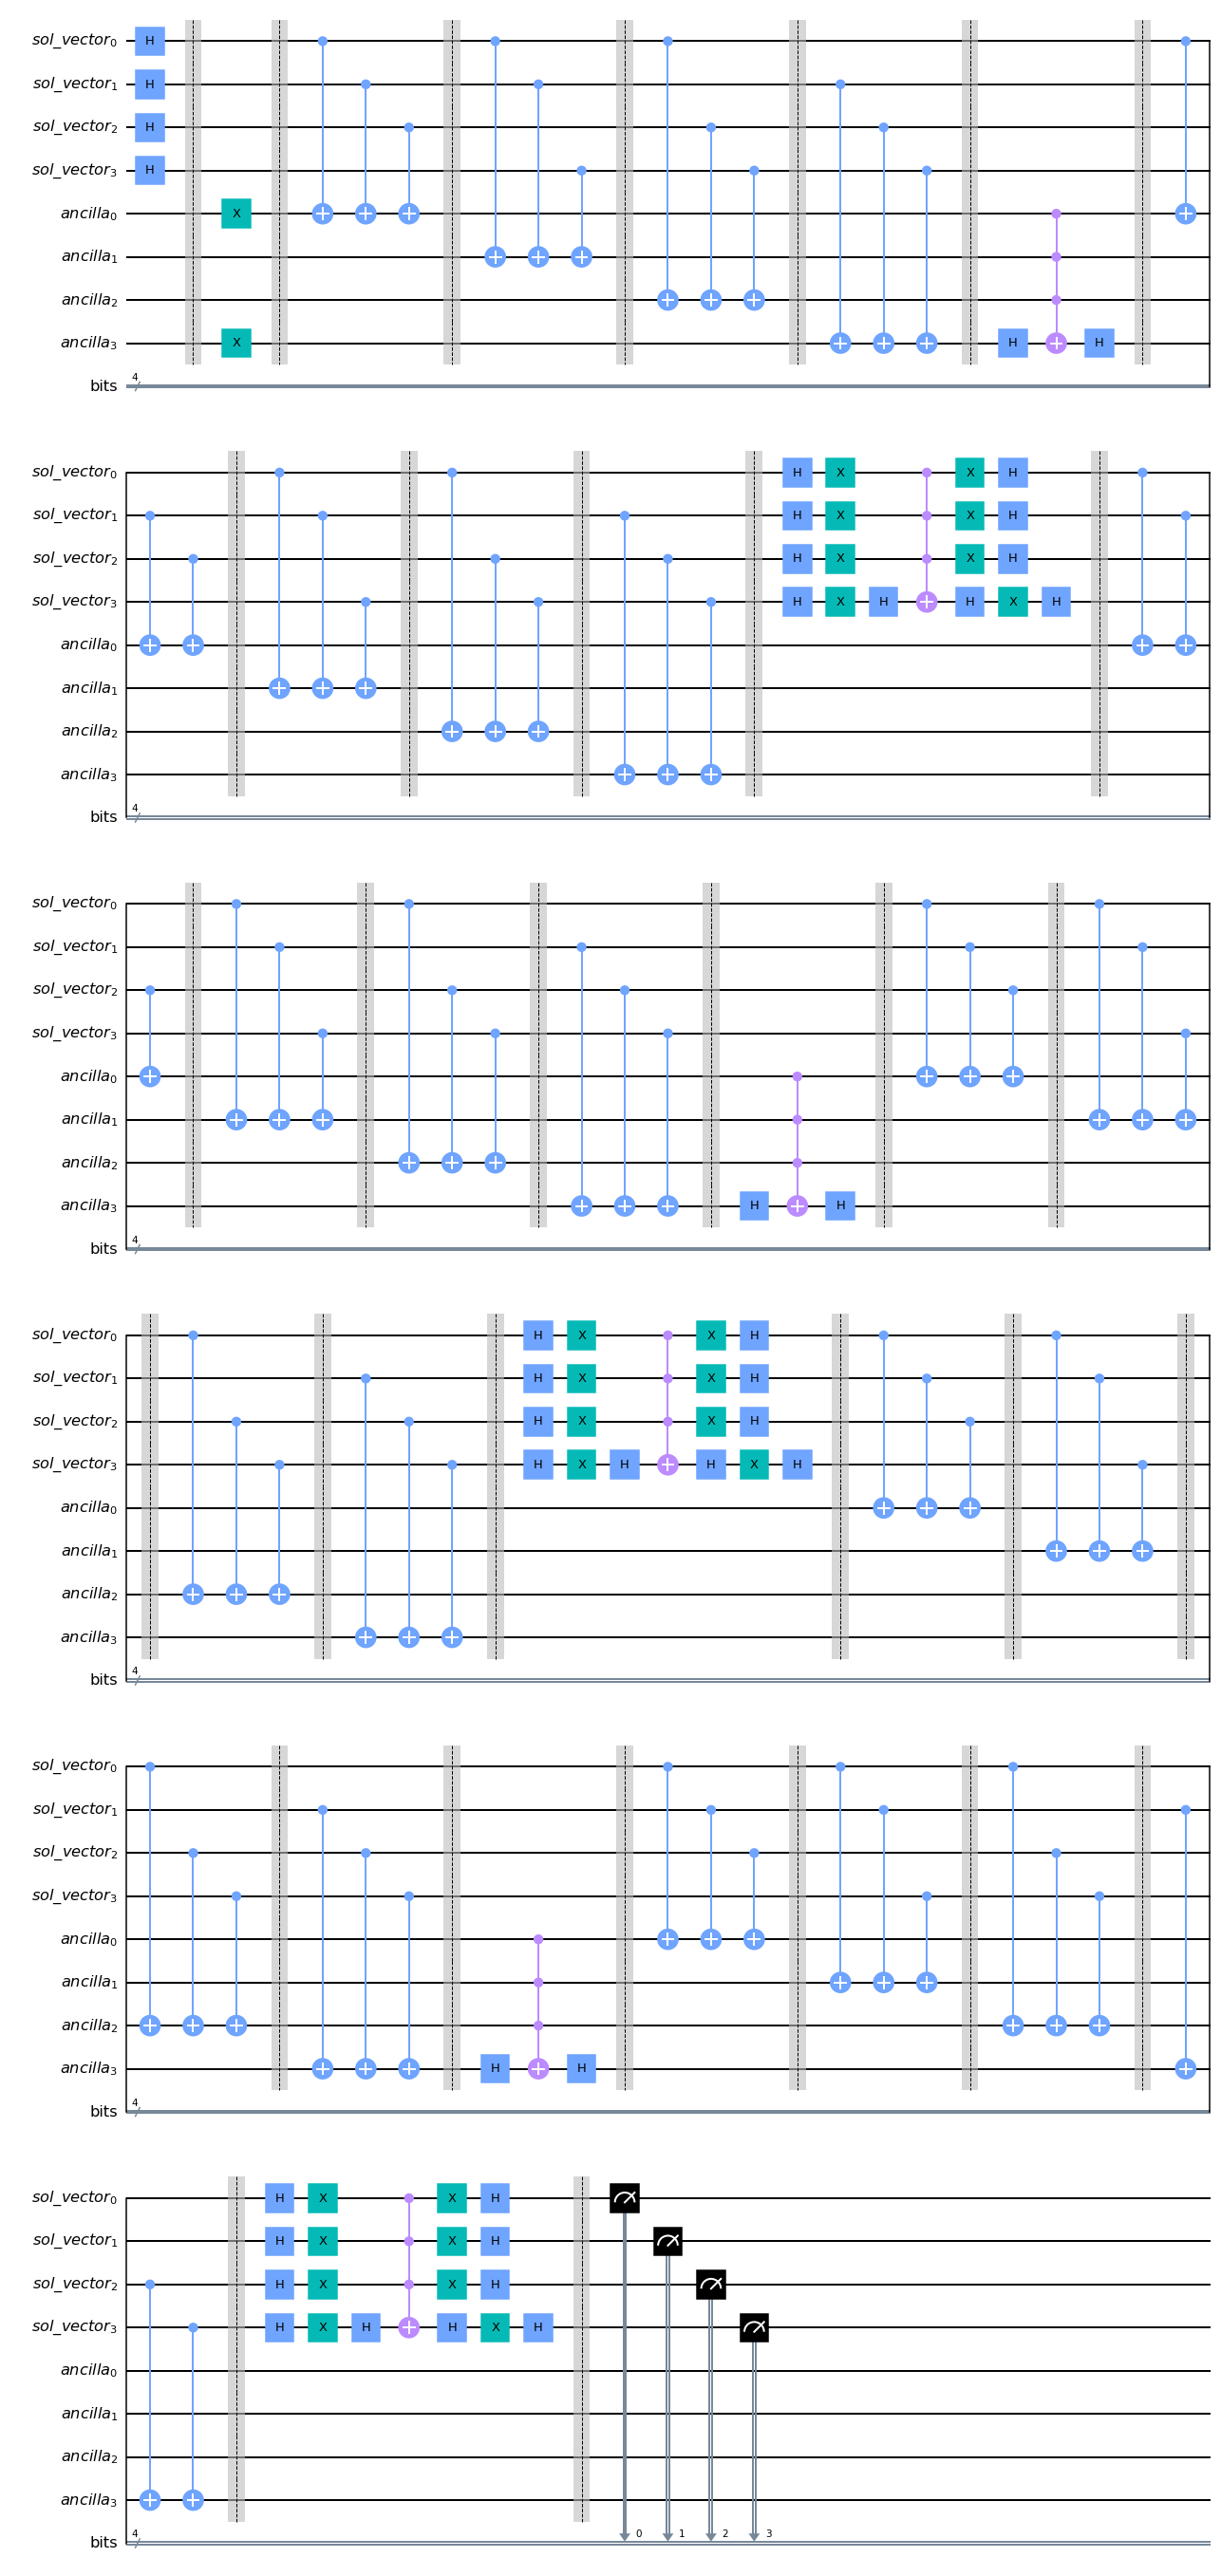

In [30]:
qc = lights_out_game_solver.create_solver_qc()
qc.draw(output = "mpl")

Executando 8192 vezes o circuito quântico acima, usando o simulador QASM, obtemos o histograma abaixo:

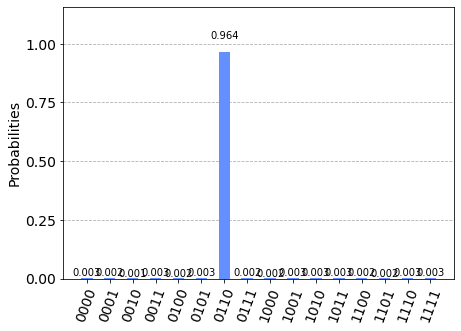

In [31]:
qc = qc.reverse_bits()
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
plot_histogram(counts)

Imprimindo a solução.

In [32]:
results = [(key, value) for key, value in counts.items() if value > 100]
print(f"Solução: {results}")

Solução: [('0110', 7899)]


Do histograma acima, podemos ver que a solução é dada pelo estado $|0110\rangle$. Na figura abaixo, podemos ver uma ilustração dessa solução.

Obs: A ordem em que vamos apagar as lâmpadas não altera o resultado, pois a soma de matriz é comutativa. Nesse caso se começarmos por apagar a lâmpada na posição 3 e depois 2, teríamos o mesmo resultado final.

![game3x3](figures/exemplo_2x2.jpg)

Agora que sabemos como resolver o caso mais simples do jogo, ou seja, um layout $2\times 2$, vamos resolver o layout $3\times 3$ proposto em [[9](https://mathworld.wolfram.com/LightsOutPuzzle.html)]. Abaixo segue uma representação gráfica do layout que queremos resolver.

![game3x3](figures/exemplo_3x3.jpg)

A lista que mapeia o layout acima é igual a: $[0, 1, 0, 1, 1, 0, 0, 1, 1]$. Passando essa lista como argumento para a classe `LightsOut`, definimos o jogo que deve ser passado posto em uma lista que é o argumento da classe `LightsOutSolver`. Usando o método `create_solver_qc()`, recebemos como retorno o circuito quântico que nos dá a solução do jogo.

In [33]:
game3x3 = LightsOut(layout = [0, 1, 0, 1, 1, 0, 0, 1, 1])
solver_game3x3 = LightsOutSolver(games = [game3x3])
qc = solver_game3x3.create_solver_qc()

Executando o circuito quântico obtido na célula acima 8192 vezes, através do simulador QASM, obtemos o seguinte resultado. 

In [34]:
qc = qc.reverse_bits()
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
results = [(key, value) for key, value in counts.items() if value > 100]
print(f"Solução: {results}")

Solução: [('111000001', 7383)]


1. Obs: O circuito para o caso $3\times 3$ foi omitido por ser muito grande.
2. Obs: O histograma fica muito poluído para 9 qubits, por isso ele não foi plotado para esse caso.

![sol3x3](figures/solucao_3x3.jpg)

### 3.2) Exemplo 2: Resolvendo 4 jogos em paralelo usando a qRAM

Agora que sabemos como o algoritmo de Grover e a qRAM funcionam, vamos juntar essas ferramentas para resolver mais de um jogo em paralelo.

De início, vamos trabalhar com os jogos com layout $2\times 2$ definidos na célula de código abaixo. Aqui vamos repetir procedimentos feitos anteriormente, nesse caso vamos definir os jogos usando a lista do layout a classe `LightsOut`, depois vamos colocar todos os jogos dentro de uma lista.

In [35]:
game1 = LightsOut(layout = [0, 1, 1, 0])
game2 = LightsOut(layout = [1, 1, 1, 0])
game3 = LightsOut(layout = [0, 1, 1, 1])
game4 = LightsOut(layout = [1, 1, 0, 1])

games_list = [game1, game2, game3, game4]

Com a lista de jogos em mãos, podemos criar nosso objeto que soluciona os jogos, para isso vamos usar a classe `LightsOutSolver` e passar `games_list` como argumento.

In [36]:
lights_out_game_solver_with_qram = LightsOutSolver(games = games_list)

Quando o tamanho da lista de jogos é maior que 1, temos a adição da qRAM ao circuito que será produzido pelo método `create_solver_qc()`. Aqui teremos 4 endereços na qRAM, nele serão armazenados os layouts dos jogos. Nesse caso a qRAM é usada para armazenar os layouts e inicializar os qubits `ancilla` da maneira correta para cada jogo. O primeiro jogo na lista encontra-se no primeiro endereço da qRAM, o segundo jogo está no segundo endereço e assim por diante.

Criando o circuito e exibindo sua estrutura.

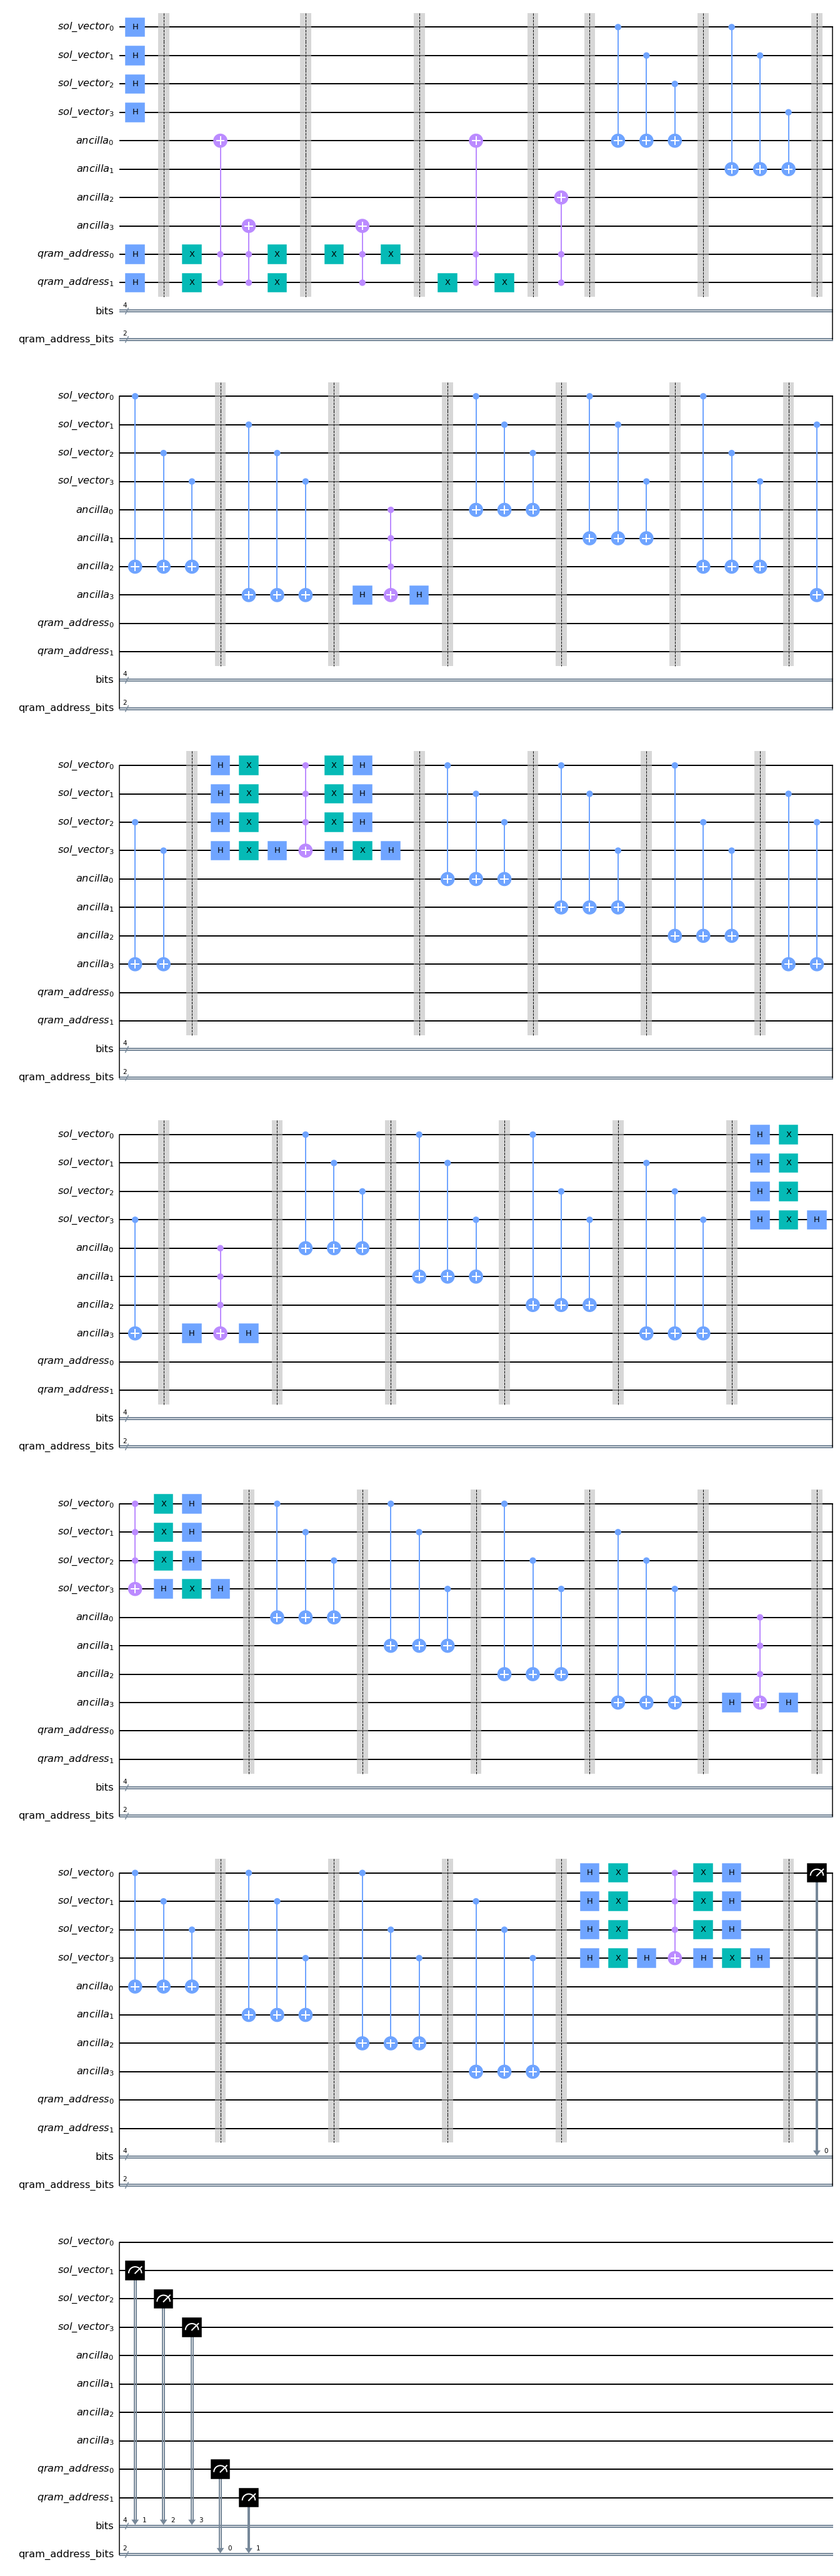

In [37]:
qc = lights_out_game_solver_with_qram.create_solver_qc()
qc.draw(output = "mpl")

Executando o experimento no simulador para obter as soluções.

In [38]:
qc = qc.reverse_bits()
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
results = [(key, value) for key, value in counts.items() if value > 100]
print(f"Soluções: {results}")

Soluções: [('0110 00', 2018), ('0001 10', 1886), ('1000 01', 2039), ('0100 11', 1965)]


Por fim, vamos resolver 4 jogos com layout $3\times 3$, em paralelo, usando qRAM. Abaixo temos a célula de código que define os jogos.

Definindo os jogos.

In [39]:
game1 = LightsOut(layout = [0, 1, 0, 1, 0, 0, 0, 0, 0])
game2 = LightsOut(layout = [1, 1, 0, 1, 0, 0, 0, 0, 0])
game3 = LightsOut(layout = [0, 1, 1, 0, 0, 0, 0, 0, 0])
game4 = LightsOut(layout = [0, 0, 1, 1, 0, 0, 0, 0, 0])

games_list = [game1, game2, game3, game4]

Representação gráfica dos jogos

![3x3qram](figures/3x3qram.jpg)

Criando o circuito e executando os experimentos.

In [40]:
lights_out_game_solver_with_qram = LightsOutSolver(games = games_list)
qc = lights_out_game_solver_with_qram.create_solver_qc()
qc = qc.reverse_bits()
counts = execute(experiments = qc, backend = qasm, shots = shots).result().get_counts()
results = [(key, value) for key, value in counts.items() if value > 100]
print(f"Soluções: {results}")

Soluções: [('100111010 11', 1854), ('001001110 00', 1873), ('100000000 01', 1819), ('101110100 10', 1803)]


## Referências:

[[1](https://arxiv.org/abs/quant-ph/9605043)] Lov K. Grover. A fast quantum mechanical algorithm for database search

[[2](https://www.youtube.com/watch?v=ePr2MgQkqL0&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=6)] Dinner Party using Grover's Algorithm — Programming on Quantum Computers — Coding with Qiskit S2E5

[[3](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/exercises/week-2/ex_2a_en.ipynb)] IBM Quantum Challenge 2020 - Exercício 2-A

[[4](https://github.com/qiskit-community/IBMQuantumChallenge2020/blob/main/exercises/week-2/ex_2b_en.ipynb)] IBM Quantum Challenge 2020 - Exercício 2-B

[[5](https://qiskit.org/textbook/ch-algorithms/grover.html)] Qiskit Textbook - Capítulo 3.8 - Grover's Algorithm

[[6](https://youtu.be/iJX794qJIpY?t=1394)] Qiskit Global Summer School 2020 - Writing and Running Quantum Programs - Part 2

[[7](https://www.youtube.com/watch?v=0RPFWZj7Jm0&list=PLOFEBzvs-VvrhKYASly1BXo1AdPyoCsor&index=3)] Grovers Algorithm — Programming on Quantum Computers — Coding with Qiskit S2E3

[[8](https://arxiv.org/abs/0708.1879)] Artigo do Seth Lloyd (e colaboradores) sobre QRAM

[[9](https://en.wikipedia.org/wiki/Lights_Out_(game))] Artigo da Wikipedia Lights Out (game)

[[10](https://mathworld.wolfram.com/LightsOutPuzzle.html)] Wolfram MathWorld - Lights Out Puzzle

[[11](https://qiskit.org/textbook/ch-states/atoms-computation.html)] Qiskit Textbook - Capítulo 1.2 - The Atoms of Computation